# **FEATURE EXTRACTION AND CLASSIFICATION**

In [1]:
# attempt = "17"
attempt = "final_multiband"

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

## **WITHOUT DENOISING (NO PREPROCESSING)**

In [2]:
# Used in BRAINS
channels_32 = ["FP1", "AF3", "F3", "FC1", "C3", "FC3", "T7", "CP5",
               "CPP1h", "P1", "P7", "P9", "PO3", "O1", "OI1h", "POz", 
               "Oz", "OI2h", "O2", "PO4", "P10", "P8", "P2", "CPP2h",
               "CP6", "T8", "FC4", "C4", "FC2", "F4", "AF4", "FP2"]

print(len(channels_32))

32


### Import Raw Dataset

In [52]:
import pandas as pd
import numpy as np
import os

path = "/kaggle/input/raw-eeg-2b"
X_batch = pd.read_csv(os.path.join(path, "X_raw_train2B.csv"), header=0)
y_batch = pd.read_csv(os.path.join(path, "y_raw_train2B.csv"), header=0)

X_batch = X_batch.to_numpy()
labels = y_batch.to_numpy().flatten()

n_channels = 32
n_timesteps = 256
X = X_batch.reshape(-1, n_channels, n_timesteps)

print(X.shape)
print(labels.shape)

(30000, 32, 256)
(30000,)


### DATA UNDERSTANDING

In [2]:
# DATA COUNT
from collections import Counter

label_counts = Counter(labels)
print(label_counts)

Counter({1: 3423, 7: 3107, 3: 3073, 9: 3003, 6: 2975, 0: 2961, 2: 2948, 4: 2926, 8: 2875, 5: 2709})


In [4]:
# Data Points per Channel
print (len(X) * n_timesteps)

# Data Points per Sample
print (n_channels * n_timesteps)

# Total Data Points
print (len(X) * n_channels * n_timesteps)

7680000
8192
245760000


### DATA PREPARATION

#### Functions: **Import BATCH Data** including Preprocessing (NOT USED ANYMORE)

In [ ]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical

def batch_generator ( df, 
                      n, 
                      start_idx, 
                      start_timestep,
                      end_timestep,
                      selected_channels,
                      batch_size,
                      stats_loc ):
    
    # Modified from: https://medium.com/analytics-vidhya/train-keras-model-with-large-dataset-batch-training-6b3099fdf366
    idx = 1
    steps = int(np.ceil(n / (batch_size // 2)))
    
    while True:
        start_row = start_idx + (idx-1) * batch_size
        skip = list(range(1, start_row + 1))
        
        print(f"Yielding batch idx={idx}, skiprows={start_row}", flush=True)
        yield load_data( df, 
                         skip, 
                         start_timestep,
                         end_timestep, 
                         selected_channels,
                         batch_size,
                         stats_loc )
        if idx < steps:
            idx += 1
        else:
            idx = 1

In [ ]:
def load_data ( df, 
                skip, 
                start_timestep,
                end_timestep, 
                selected_channels,
                batch_size,
                stats_loc ):
    
    # Modified from: https://medium.com/analytics-vidhya/train-keras-model-with-large-dataset-batch-training-6b3099fdf366
    df = pd.read_csv (
                  df, 
                  skiprows = skip,
                  nrows    = batch_size )
    n_channels = len(selected_channels)
    n_timesteps = (end_timestep - start_timestep) + 1

    # Remove Data with Label -1
    data = df[df['label'] != -1]

    # Take Selected Channels and Timesteps' Columns
    selected_columns = [col for col in data.columns
                        if any(col.startswith(ch + '_') \
                               and start_timestep <= int(col.split('_')[-1]) <= end_timestep
                               for ch in selected_channels)
                        or col == 'label']
    data = data[selected_columns].astype(np.float32)

    
    # NORMALIZATION
    if (stats_loc != ''):
        stats_df = pd.read_csv(stats_loc)
        for idx, ch_name in enumerate(selected_channels):
            ch_mean = stats_df.loc[stats_df['channel'] == ch_name, 'mean'].values[0]
            ch_std = stats_df.loc[stats_df['channel'] == ch_name, 'std'].values[0]
            
            start_col = idx * n_timesteps
            end_col = (idx + 1) * n_timesteps
        
            data.iloc[:, start_col:end_col] = \
                (data.iloc[:, start_col:end_col] - ch_mean) / ch_std

    
    # INTEGRATION AND RESHAPE
    data_array = data.iloc[:, :-1].values \
                                  .reshape((-1, n_channels, n_timesteps)) \
                                  .transpose(0, 2, 1) \
                                  .astype(np.float32)
    labels = data['label'].values

    
    return (data_array, to_categorical(labels, num_classes=10).astype('float32'))

#### Split Data: Train, Validation

In [54]:
from keras.utils import to_categorical

X_transposed = X.transpose(0, 2, 1).astype('float32')
y_cat = to_categorical(labels, num_classes=10).astype('float32')

print(X_transposed.shape)
print(y_cat.shape)

(30000, 256, 32)
(30000, 10)


In [66]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split (
    X_transposed, 
    y_cat, 
    test_size    = 0.2,
    random_state = 42, 
    shuffle      = True, 
    stratify     = y_cat
)

In [ ]:
# train_generator     = batch_generator (
#     df                = '/kaggle/input/raw-eeg/test.csv',
#     n                 = 8000,
#     start_idx         = 0,
#     start_timestep    = 1,
#     end_timestep      = 50,
#     selected_channels = channels_32,
#     batch_size        = 2*800,
#     stats_loc         = '/kaggle/input/test-channels-stats/channel_stats.csv'
# )

# val_generator         = batch_generator (
#     df                = '/kaggle/input/raw-eeg/test.csv',
#     n                 = 2000,
#     start_idx         = 16000,
#     start_timestep    = 1,
#     end_timestep      = 50,
#     selected_channels = channels_32,
#     batch_size        = 2*2000,
#     stats_loc         = '/kaggle/input/test-channels-stats/channel_stats.csv'
# )

### **Define Topology**

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Attention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, TimeDistributed, Flatten
import tensorflow as tf

latent_dim = 100
num_classes = 10

# Input
# 32 channels, 256 timestamps
inputs = Input(shape=(256, 32))

# Encoder
x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(128, return_sequences=True)(x)

attention_output = Attention()([x, x])
attention_output = LayerNormalization()(Add()([x, attention_output]))

global_feat = GlobalAveragePooling1D()(attention_output)
latent_output = Dense(latent_dim, activation='tanh', name='latent_vector')(global_feat)

# CLASSIFICATION
x = Dense(64, activation='relu')(latent_output)
x = Dropout(0.3)(x)
classifier_output = Dense(num_classes, activation='softmax', name='class_output')(x)

#### Instantiate Classification Model

In [88]:
from tensorflow.keras.metrics import Precision, Recall

thetrial_model = Model(inputs=inputs, outputs=classifier_output)
thetrial_model.compile (
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy', Precision(), Recall()]
)
thetrial_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 32)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 256, 128)       │         82,432 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256, 128)       │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 256, 128)       │        131,584 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256, 128)       │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 256, 128)       │        131,584 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 256, 128)       │              0 │ lstm_8[0][0],          │
│                           │                        │                │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 128)       │              0 │ lstm_8[0][0],          │
│                           │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_vector (Dense)     │ (None, 100)            │         12,900 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          6,464 │ latent_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 10)             │            650 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 365,870 (1.40 MB)

 Trainable params: 365,870 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    f'best_thetrial_LSTM_{attempt}.keras',
    monitor        = 'val_accuracy',
    save_best_only = True,
    mode           = 'max'
)

In [90]:
thetrial_history = thetrial_model.fit (
    X_train, y_train,
    epochs           = 200,
    batch_size       = 256,
    validation_data  = (X_val, y_val),
    callbacks        = [model_checkpoint],
    shuffle          = True
)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6560 - loss: 0.9670 - precision_5: 0.8416 - recall_5: 0.5296 - val_accuracy: 0.1463 - val_loss: 5.0692 - val_precision_5: 0.1716 - val_recall_5: 0.1037
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.6662 - loss: 0.9376 - precision_5: 0.8469 - recall_5: 0.5413 - val_accuracy: 0.1427 - val_loss: 5.0525 - val_precision_5: 0.1730 - val_recall_5: 0.1045
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.6619 - loss: 0.9563 - precision_5: 0.8502 - recall_5: 0.5335 - val_accuracy: 0.1463 - val_loss: 5.0946 - val_precision_5: 0.1739 - val_recall_5: 0.1065
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.6717 - loss: 0.9405 - precision_5: 0.8565 - recall_5: 0.5426 - val_accuracy: 0.1510 - val_loss: 5.0797 - val_precision_5: 0.1754 - val_recall_5: 0.1058
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6615 - loss: 0.9465 - precision_5: 0.8510 - recall_5

In [93]:
import tensorflow as tf
import os

save_dir = f"/kaggle/working/"
best_thetrial_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_thetrial_LSTM_{attempt}.keras'))

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.135     0.145     0.140       592
           1      0.149     0.153     0.151       685
           2      0.185     0.214     0.198       590
           3      0.168     0.190     0.178       615
           4      0.147     0.133     0.140       585
           5      0.126     0.129     0.128       542
           6      0.120     0.099     0.109       595
           7      0.145     0.161     0.153       621
           8      0.159     0.155     0.157       575
           9      0.183     0.138     0.158       600

    accuracy                          0.152      6000
   macro avg      0.152     0.152     0.151      6000
weighted avg      0.152     0.152     0.151      6000



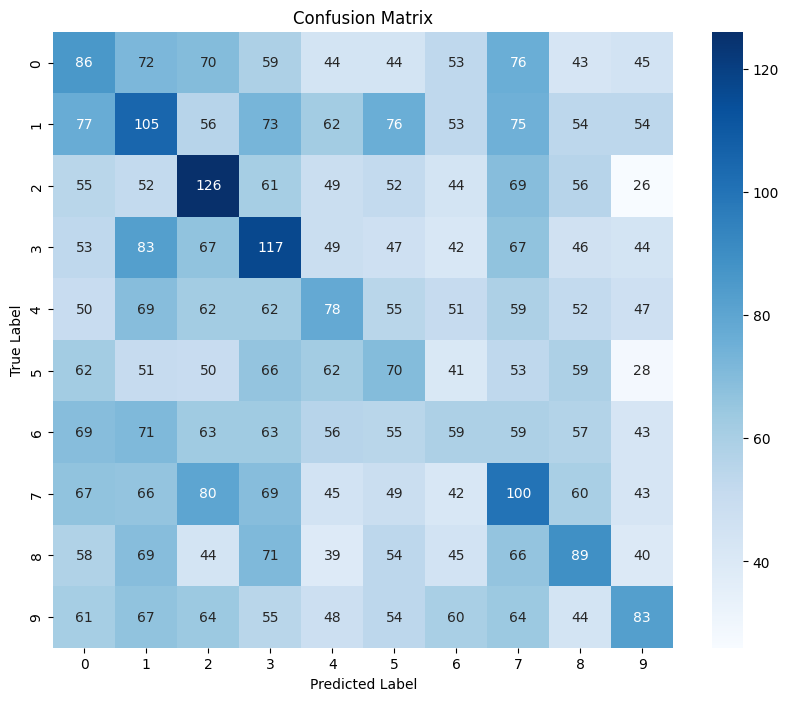

In [98]:
evaluate_model(best_thetrial_model, X_val, y_val, class_names)

In [68]:
from tensorflow.keras.metrics import Precision, Recall

trial_model = Model(inputs=inputs, outputs=classifier_output)
trial_model.compile (
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy', Precision(), Recall()]
)
trial_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 32)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 256, 128)       │         82,432 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256, 128)       │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 256, 128)       │        131,584 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 256, 128)       │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 256, 128)       │        131,584 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 256, 128)       │              0 │ lstm_8[0][0],          │
│                           │                        │                │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 128)       │              0 │ lstm_8[0][0],          │
│                           │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_vector (Dense)     │ (None, 100)            │         12,900 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          6,464 │ latent_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 10)             │            650 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 365,870 (1.40 MB)

 Trainable params: 365,870 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    f'best_trial_LSTM_{attempt}.keras',
    monitor        = 'val_accuracy',
    save_best_only = True,
    mode           = 'max'
)

### Training Start! With NO PREPROCESSING (Denoising), No Upsampling

In [69]:
trial_history = trial_model.fit (
    X_train, y_train,
    epochs           = 200,
    batch_size       = 256,
    validation_data  = (X_val, y_val),
    callbacks        = [model_checkpoint],
    shuffle          = True
)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5793 - loss: 1.1690 - precision_4: 0.8480 - recall_4: 0.4279 - val_accuracy: 0.1842 - val_loss: 4.0889 - val_precision_4: 0.2462 - val_recall_4: 0.1227
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.5843 - loss: 1.1675 - precision_4: 0.8522 - recall_4: 0.4316 - val_accuracy: 0.1878 - val_loss: 4.0265 - val_precision_4: 0.2475 - val_recall_4: 0.1192
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5909 - loss: 1.1510 - precision_4: 0.8513 - recall_4: 0.4385 - val_accuracy: 0.1815 - val_loss: 4.0827 - val_precision_4: 0.2456 - val_recall_4: 0.1205
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5825 - loss: 1.1610 - precision_4: 0.8448 - recall_4: 0.4331 - val_accuracy: 0.1848 - val_loss: 4.0633 - val_precision_4: 0.2441 - val_recall_4: 0.1197
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.5885 - loss: 1.1527 - precision_4: 0.8550 - recall_4

#### Plot Training History

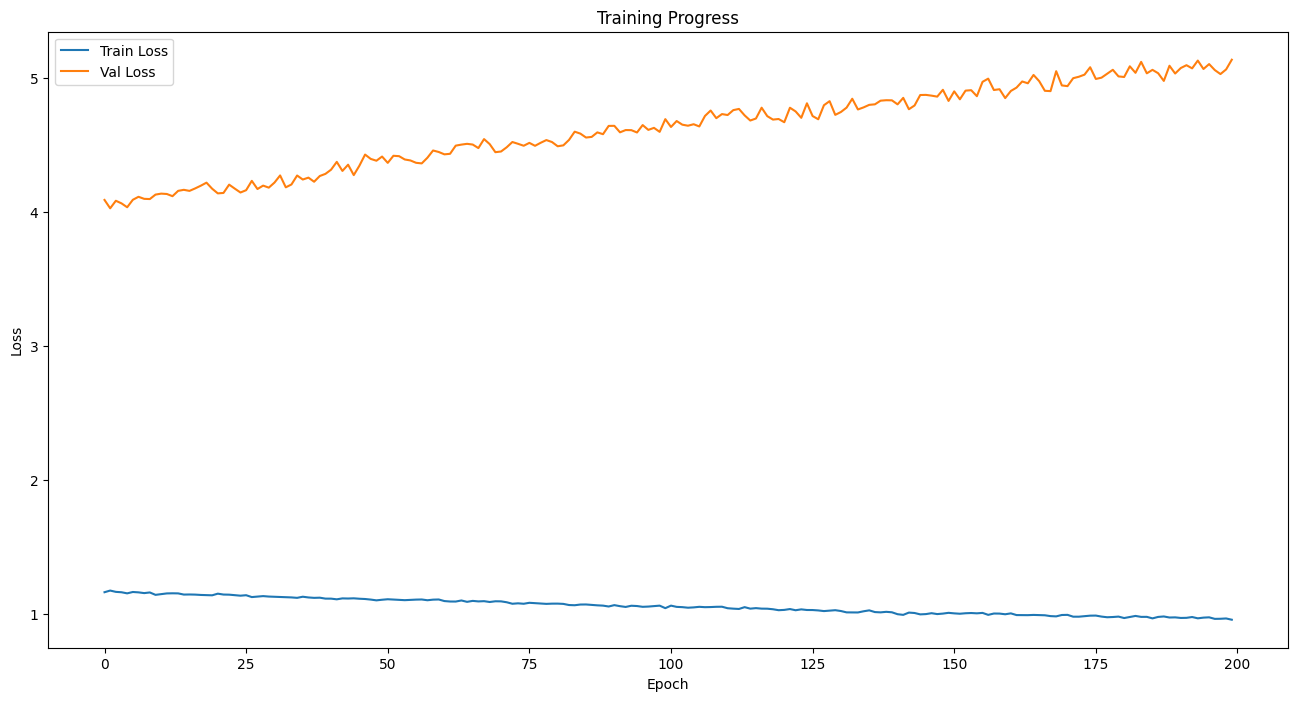

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(trial_history.history['loss'], label='Train Loss')
plt.plot(trial_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

#### Save Last Model

In [73]:
import json
import os

save_dir = f"LSTM_{attempt}"
os.makedirs(save_dir, exist_ok=True)

# SAVE LAST MODEL
model_path = os.path.join(save_dir, f"trial_LSTM_{attempt}.keras")
trial_model.save(model_path)

history_path = os.path.join(save_dir, "trial_training_history.json")
with open(history_path, "w") as f:
    json.dump(trial_history.history, f)

## **WITH DENOISING (PREPROCESSING)**

### Import Preprocessed Data

In [4]:
import os
import pickle
import numpy as np

path = '/kaggle/input/preprocessed-multiband/'
with open(os.path.join(path, 'preprocessed_multiband_eeg.pkl'), "rb") as f:
    data = pickle.load(f)

print(data.keys())
print(data['X']['delta'].shape)
print(data['y'].shape)

dict_keys(['X', 'y', 'augmented_indices', 'augmentation_methods', 'duplication_sources'])
(34230, 32, 125)
(34230,)


In [5]:
from keras.utils import to_categorical

X = np.stack([
    data['X']['delta'],
    data['X']['theta'],
    data['X']['alpha'],
    data['X']['beta']
], axis=1)
X = np.transpose(X, (0, 1, 3, 2))

y = to_categorical(data["y"], num_classes=10)

print(X.shape)
print(y.shape)

(34230, 4, 125, 32)
(34230, 10)


In [5]:
print(len(data['augmented_indices']))
print(len(data['augmentation_methods']))
print(len(data['duplication_sources']))

4230
4230
4230


In [8]:
not_augmented_flag = ["-1"] * 30000
all_idx = [i for i in range(30000)] + data['augmented_indices']
aug_met = not_augmented_flag + data['augmentation_methods']
dup_src = not_augmented_flag + data['duplication_sources']

print(len(all_idx))
print(len(aug_met))
print(len(dup_src))

34230
34230
34230


#### Split Data: Train, Validation

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val,           \
y_train, y_val,           \
allidx_train, allidx_val, \
augmet_train, augmet_val, \
dupsrc_train, dupsrc_val  \
    = train_test_split (
        X, 
        y, 
        all_idx,
        aug_met,
        dup_src,
    
        test_size    = 0.2,
        random_state = 42, 
        shuffle      = True, 
        stratify     = y
    )

In [8]:
n_augmented_in_train = sum(elm > 29999 for elm in allidx_train)
n_augmented_in_val = sum(elm > 29999 for elm in allidx_val)

print(f"{n_augmented_in_train} augmented data in train set: {round(n_augmented_in_train/len(allidx_train), 4) * 100}%")
print(f"{n_augmented_in_val}  augmented data in val set: {round(n_augmented_in_val/len(allidx_val), 4) * 100}%")

3347 augmented data in train set: 12.22%
883  augmented data in val set: 12.9%


In [9]:
not_reinforced = sum ( 1 
                      for (idx, elm) in enumerate(allidx_val) 
                      if elm > 29999 and 
                      dupsrc_val[idx] not in allidx_train
                     )
print(f"{not_reinforced} elements in validation set was not augmented from train set: {round(not_reinforced/len(allidx_val), 4) * 100}%")

528 elements in validation set was not augmented from train set: 7.71%


### **Define Topology**

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Attention, LayerNormalization, Add,
    GlobalAveragePooling1D, TimeDistributed
)
from tensorflow.keras.regularizers import l1_l2

latent_dim = 100
num_classes = 10

# Input EEG: 4 bands, 125 timesteps, 32 channels
inputs = Input(shape=(4, 125, 32))

# === Step 1: SHARED ENCODER ===
def build_band_encoder():
    inp = Input(shape=(125, 32))
    x = LSTM(128, return_sequences=True,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inp)
    x = Dropout(0.4)(x)
    x = LSTM(128, return_sequences=True,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.4)(x)
    x = LSTM(128, return_sequences=True,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)

    # Self-attention block (intra-band)
    attn = Attention()([x, x])
    attn = LayerNormalization()(Add()([x, attn]))

    global_feat = GlobalAveragePooling1D()(attn)
    return Model(inputs=inp, outputs=global_feat, name="band_encoder")

band_encoder = build_band_encoder()
# Output: (batch, 4, 128)
encoded_bands = TimeDistributed(band_encoder)(inputs)



# === Step 2: INTER-BAND ATTENTION ===
attn_inter        = Attention()([encoded_bands, encoded_bands])
attn_inter        = LayerNormalization()(Add()([encoded_bands, attn_inter]))
x                 = LSTM(128, return_sequences=False,
                         kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(attn_inter)



# === Step 3: LATENT & CLASSIFICATION ===
latent_output     = Dense(latent_dim, activation='tanh',
                          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                          name='latent_vector')(x)
x                 = Dense(64, activation='relu',
                    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(latent_output)
x                 = Dropout(0.4)(x)
classifier_output = Dense(num_classes, activation='softmax',
                          kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                          name='class_output')(x)

2025-07-16 09:25:17.889462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752657918.255737      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752657918.363931      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752657936.245856      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752657936.246546      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

#### Instantiate Classification Model

In [3]:
from tensorflow.keras.metrics import Precision, Recall

model = Model(inputs=inputs, outputs=classifier_output)
model.compile (
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy', Precision(), Recall()]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 125,    │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 128)    │    345,856 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 4, 128)    │          0 │ time_distributed… │
│ (Attention)         │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 128)    │          0 │ time_distributed… │
│                     │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 128)    │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_vector       │ (None, 100)       │     12,900 │ lstm_3[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ latent_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 10)        │        650 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 497,710 (1.90 MB)

 Trainable params: 497,710 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping (
    monitor              = 'val_accuracy',       
    patience             = 15,               
    mode                 = 'max',
    verbose              = 1,
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint (
    f'best_LSTM_{attempt}.keras',
    monitor              = 'val_loss',
    save_best_only       = True,
    mode                 = 'min',
    verbose              = 1
)

reduce_lr = ReduceLROnPlateau (
    monitor              = 'val_loss',
    factor               = 0.5,
    patience             = 10,
    min_lr               = 1e-6,
    verbose              = 1
)

### Training Start! With ALL Denoising (Preprocessing)

In [20]:
history = model.fit (
    X_train, y_train,
    epochs           = 100,
    batch_size       = 64,
    validation_data  = (X_val, y_val),
    callbacks        = [early_stop, model_checkpoint, reduce_lr],
    shuffle          = True
)

Epoch 1/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1101 - loss: 2.5167 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.49509, saving model to best_LSTM_final_multiband.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.1101 - loss: 2.5167 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 2.4951 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1170 - loss: 2.4918 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_loss improved from 2.49509 to 2.47081, saving model to best_LSTM_final_multiband.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.1170 - loss: 2.4918 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.1392 - val_loss: 2.4708 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
428/428 ━━━━

#### Plot Training History

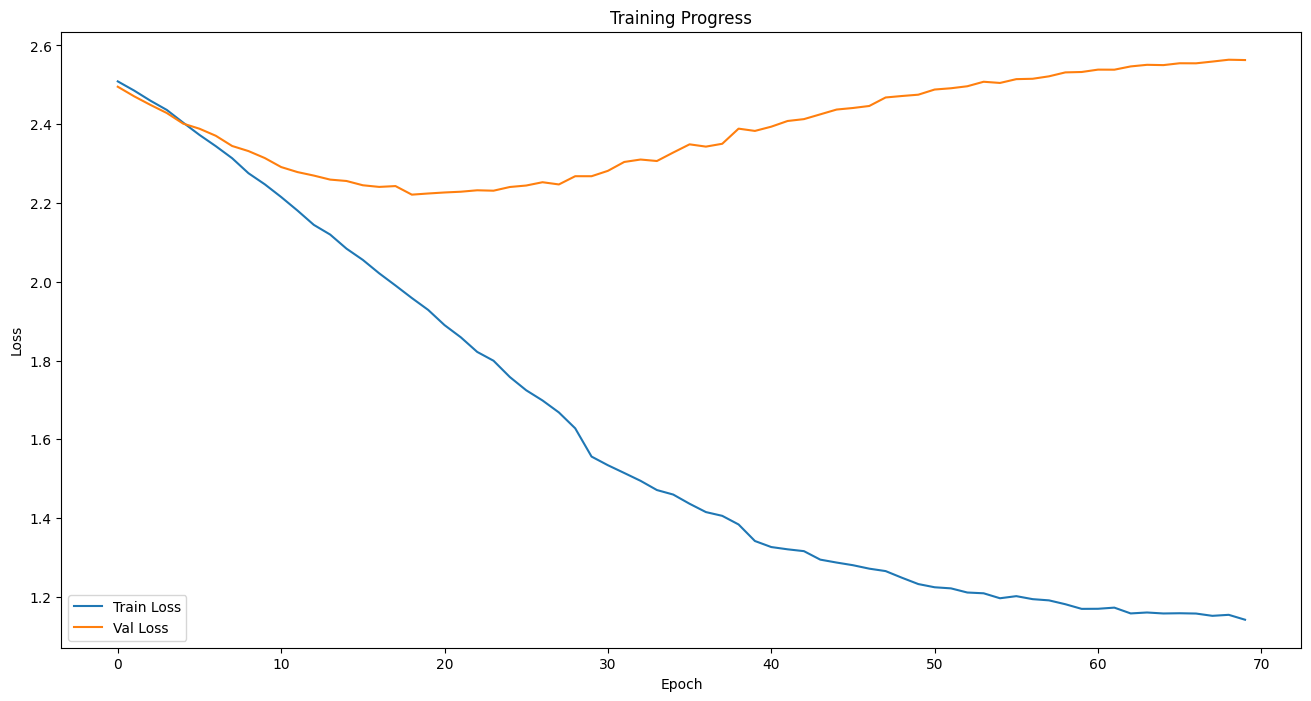

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

#### Save Last Model

In [22]:
import json
import os

save_dir = f"/kaggle/working"

# SAVE LAST MODEL
model_path = os.path.join(save_dir, f"LSTM_{attempt}.keras")
model.save(model_path)

history_path = os.path.join(save_dir, f"training_history_{attempt}.json")
with open(history_path, "w") as f:
    json.dump(history.history, f)

## **EVALUATION**

### FUNCTIONS

In [17]:
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cosine, euclidean

def theta_difference(v1, v2):
    # Cosine similarity
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta) * (180 / np.pi)
    return theta


def cosine_stats(latent_vectors, labels):
    class_stats = defaultdict(dict)
    unique_labels = np.unique(labels)

    for label in unique_labels:
        # Filter latent vectors for current class
        class_vectors = latent_vectors[labels == label]
        num_vectors = class_vectors.shape[0]

        differences = []
        for i in range(num_vectors):
            for j in range(i + 1, num_vectors):
                theta = theta_difference(class_vectors[i], class_vectors[j])
                differences.append(theta)

        class_stats[label]['min_theta'] = np.min(differences)
        class_stats[label]['max_theta'] = np.max(differences)
        class_stats[label]['avg_theta'] = np.mean(differences)

    return class_stats


def euclidean_stats(latent_vectors, labels):
    class_stats = defaultdict(dict)
    unique_labels = np.unique(labels)

    for label in unique_labels:
        # Filter latent vectors for current class
        class_vectors = latent_vectors[labels == label]
        num_vectors = class_vectors.shape[0]

        distances = []
        for i in range(num_vectors):
            for j in range(i + 1, num_vectors):
                dist = euclidean(class_vectors[i], class_vectors[j])
                distances.append(dist)

        class_stats[label]['min_euclidean'] = np.min(distances)
        class_stats[label]['max_euclidean'] = np.max(distances)
        class_stats[label]['avg_euclidean'] = np.mean(distances)

    return class_stats


def calculate_metrics(latent_vectors, labels):
    cosine_results = cosine_stats(latent_vectors, labels)
    euclidean_results = euclidean_stats(latent_vectors, labels)
    combined_results = {}
    for label in set(list(cosine_results.keys()) + list(euclidean_results.keys())):
        combined_results[label] = {
            **cosine_results.get(label, {}),
            **euclidean_results.get(label, {})
        }
    return combined_results


def print_metrics(metrics_dict):
    print("\n\n=================================================== METRICS  SUMMARY ===================================================")
    headers = ["Label", "Theta Min", "Theta Max", "Theta Avg", "Euclidean Min", "Euclidean Max", "Euclidean Avg"]
    print(f"{headers[0]:<10} | {headers[1]:<15} | {headers[2]:<15} | {headers[3]:<15} | {headers[4]:<15} | {headers[5]:<15} | {headers[6]:<15}")
    print("-" * 120)

    for label, metrics in metrics_dict.items():
        theta_min = metrics['min_theta']
        theta_max = metrics['max_theta']
        theta_avg = metrics['avg_theta']
        euclidean_min = metrics['min_euclidean']
        euclidean_max = metrics['max_euclidean']
        euclidean_avg = metrics['avg_euclidean']

        print(f"{label:<10} | {theta_min:<15.6f} | {theta_max:<15.6f} | {theta_avg:<15.6f} | {euclidean_min:<15.6f} | {euclidean_max:<15.6f} | {euclidean_avg:<15.6f}")

    print("-" * 120)

In [18]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def visualize_tSNE(perplexity, lr, X_batch, labels, title, n_comp):
    if (n_comp != 2 and n_comp != 3):
        print("Number of components must be 2 or 3")
        return
    
    data_flat = X_batch.reshape(X_batch.shape[0], -1)
    
    tsne = TSNE ( 
        n_components  = n_comp,
        perplexity    = perplexity,
        learning_rate = lr,
        n_iter        = 1000,
        random_state  = 42,
        init          = 'pca',
    )
    embedding = tsne.fit_transform(data_flat)
    
   
    if (n_comp == 2):
        plt.figure(figsize=(8,6))
        for label in np.unique(labels):
            idxs = labels == label
            plt.scatter (
                embedding[idxs, 0], 
                embedding[idxs, 1],
                label=f"Label {label}", 
                alpha=0.6
            )
        plt.title(f"{title}, perplexity:{perplexity}, learning_rate:{lr}")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    elif (n_comp == 3):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(labels):
            idxs = labels == label
            ax.scatter(
                embedding[idxs, 0],
                embedding[idxs, 1],
                embedding[idxs, 2],
                label=f"Label {label}",
                alpha=0.6
            )
        ax.set_title(f"{title}, perplexity:{perplexity}, learning_rate:{lr}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        ax.legend()
        plt.tight_layout()
        plt.show()

    print(f"Final KL-Divergence: {tsne.kl_divergence_}")

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_val, y_val, class_names=None):
    y_true = np.argmax(y_val, axis=1)
    
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=3, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### **WITHOUT DENOISING**

#### LAST MDOEL

750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.792     0.765     0.778      2369
           1      0.750     0.814     0.781      2738
           2      0.798     0.757     0.777      2358
           3      0.842     0.764     0.801      2458
           4      0.799     0.765     0.782      2341
           5      0.745     0.775     0.760      2167
           6      0.723     0.803     0.761      2380
           7      0.783     0.790     0.786      2486
           8      0.755     0.748     0.751      2300
           9      0.797     0.779     0.788      2403

    accuracy                          0.777     24000
   macro avg      0.778     0.776     0.776     24000
weighted avg      0.778     0.777     0.777     24000



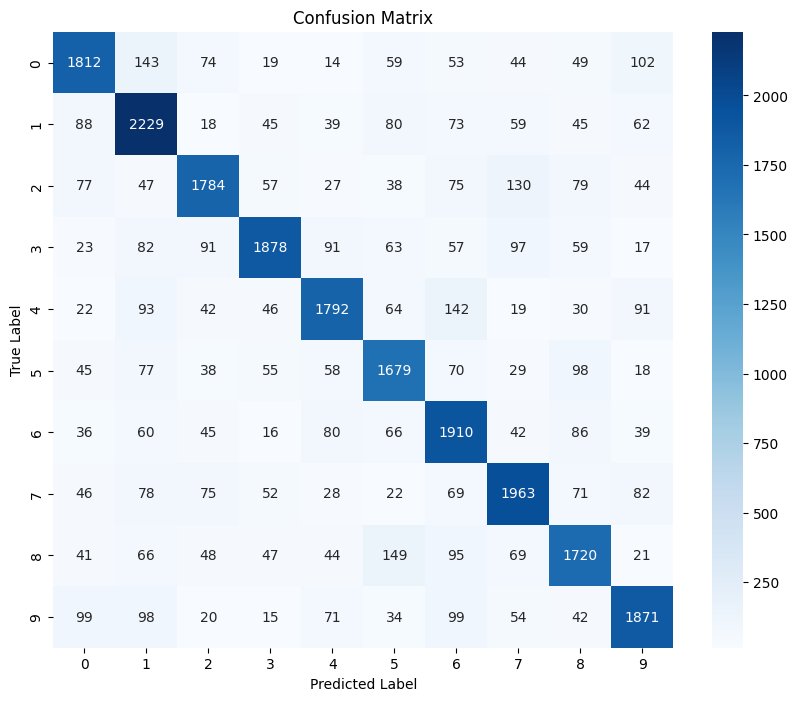

In [87]:
class_names = [str(i) for i in range(10)]
evaluate_model(trial_model, X_train, y_train, class_names)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.133     0.106     0.118       592
           1      0.142     0.165     0.153       685
           2      0.182     0.169     0.175       590
           3      0.182     0.164     0.173       615
           4      0.144     0.130     0.136       585
           5      0.129     0.142     0.135       542
           6      0.106     0.123     0.114       595
           7      0.140     0.140     0.140       621
           8      0.139     0.157     0.147       575
           9      0.157     0.142     0.149       600

    accuracy                          0.144      6000
   macro avg      0.145     0.144     0.144      6000
weighted avg      0.146     0.144     0.144      6000



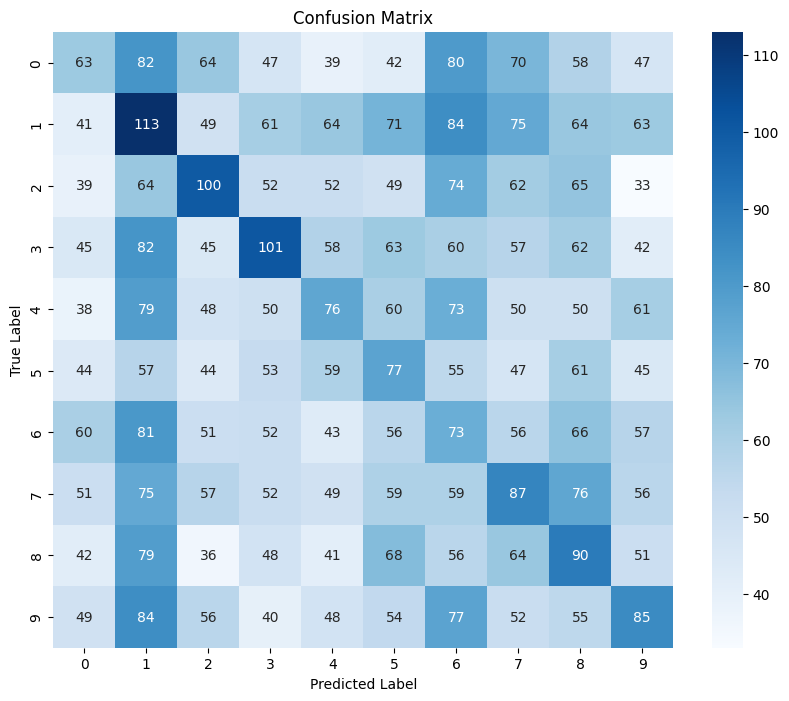

In [74]:
evaluate_model(trial_model, X_val, y_val, class_names)

#### BEST MODEL

In [99]:
import tensorflow as tf
import os

save_dir = f"/kaggle/working/"
best_trial_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_trial_LSTM_{attempt}.keras'))

##### TRAIN DATA

750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.491     0.562      2369
           1      0.491     0.622     0.549      2738
           2      0.607     0.593     0.600      2358
           3      0.639     0.574     0.605      2458
           4      0.575     0.560     0.568      2341
           5      0.548     0.541     0.544      2167
           6      0.557     0.532     0.544      2380
           7      0.576     0.584     0.580      2486
           8      0.538     0.563     0.550      2300
           9      0.544     0.593     0.567      2403

    accuracy                          0.567     24000
   macro avg      0.573     0.565     0.567     24000
weighted avg      0.572     0.567     0.567     24000



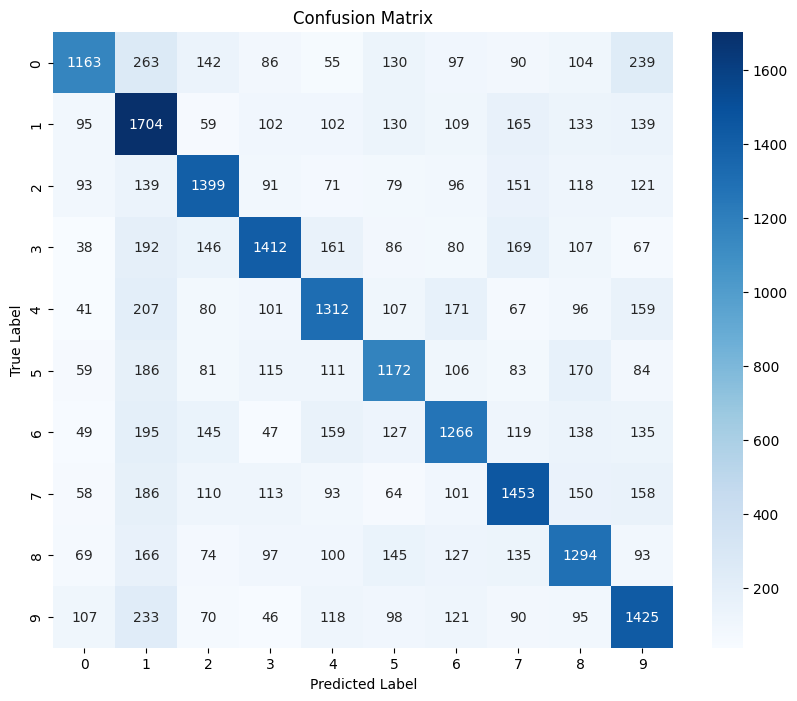

In [100]:
evaluate_model(best_trial_model, X_train, y_train, class_names)

In [101]:
from tensorflow.keras.models import Model
trial_encoder_model = Model(inputs=best_trial_model.input, outputs=best_trial_model.get_layer('latent_vector').output)
trial_encoder_model.compile()

In [81]:
latent_vectors = trial_encoder_model.predict(X_train)
y_true_train = np.argmax(y_train, axis=1)
print_metrics(calculate_metrics(latent_vectors, y_true_train))

750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


=================================================== METRICS  SUMMARY ===================================================
Label      | Theta Min       | Theta Max       | Theta Avg       | Euclidean Min   | Euclidean Max   | Euclidean Avg  
------------------------------------------------------------------------------------------------------------------------
0          | 20.211807       | 125.380896      | 72.571282       | 2.890767        | 14.212074       | 8.895082       
1          | 18.438292       | 128.529455      | 73.614779       | 2.490793        | 14.229418       | 8.997133       
2          | 17.043730       | 127.166098      | 73.230663       | 2.509876        | 14.456494       | 8.991343       
3          | 16.538660       | 128.738465      | 72.957702       | 2.362885        | 13.999850       | 8.947523       
4          | 17.085986       | 124.190172      | 71.689570       | 2.361784        | 14.129547       | 8.848449       


750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


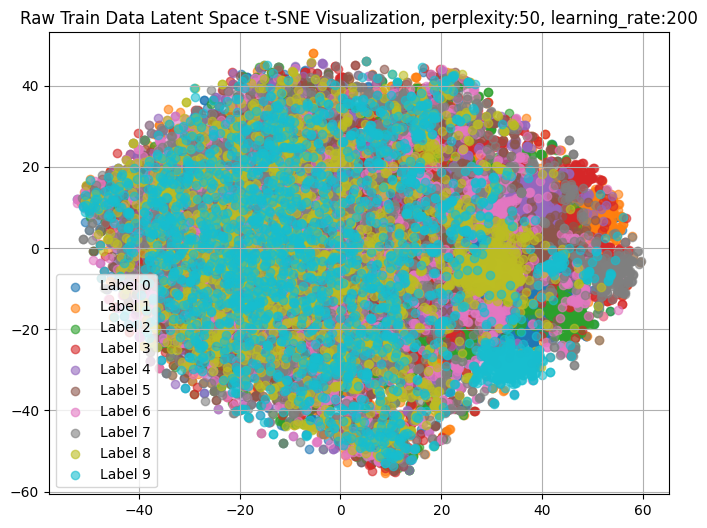

Final KL-Divergence: 3.834502935409546


In [83]:
perplexities = [50]
learning_rates = [200]

latent_vectors = trial_encoder_model.predict(X_train)
y_true_train = np.argmax(y_train, axis=1)

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_train, "Raw Train Data Latent Space t-SNE Visualization", 2)

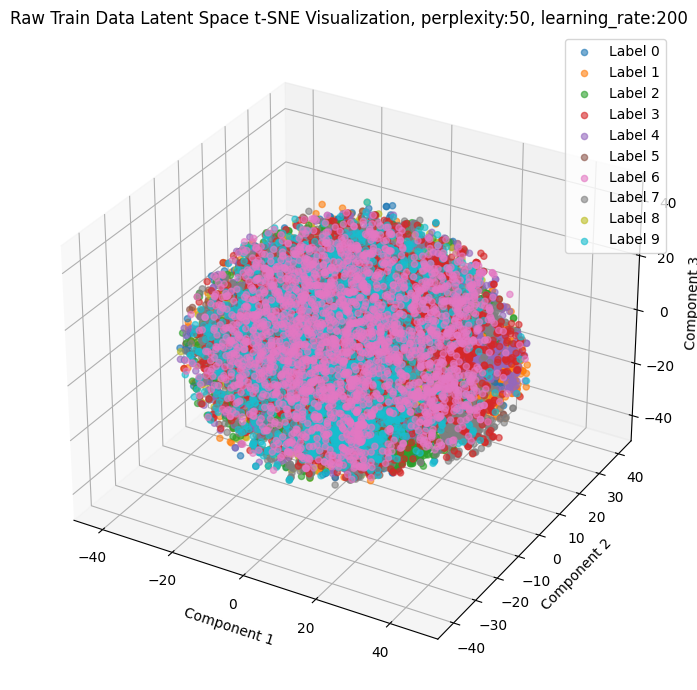

Final KL-Divergence: 3.5828537940979004


In [84]:
for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_train, "Raw Train Data Latent Space t-SNE Visualization", 3)

##### VALIDATION DATA

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.368     0.258     0.304       592
           1      0.309     0.396     0.347       685
           2      0.352     0.341     0.346       590
           3      0.343     0.315     0.329       615
           4      0.303     0.313     0.308       585
           5      0.322     0.301     0.311       542
           6      0.309     0.323     0.316       595
           7      0.307     0.314     0.311       621
           8      0.310     0.320     0.315       575
           9      0.296     0.302     0.299       600

    accuracy                          0.320      6000
   macro avg      0.322     0.318     0.318      6000
weighted avg      0.322     0.320     0.319      6000



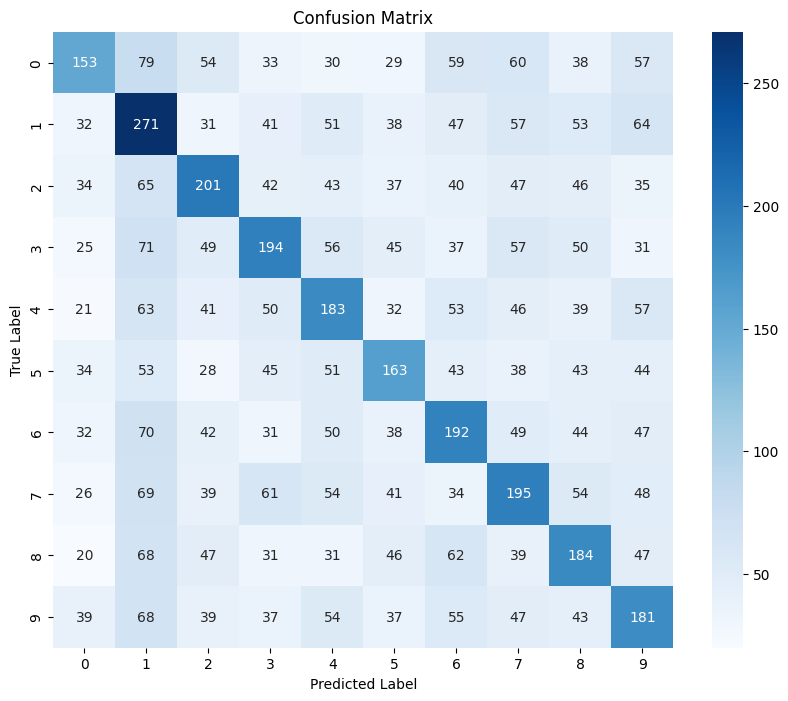

In [102]:
evaluate_model(best_trial_model, X_val, y_val, class_names)

In [80]:
latent_vectors = trial_encoder_model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)
print_metrics(calculate_metrics(latent_vectors, y_true_val))

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


=================================================== METRICS  SUMMARY ===================================================
Label      | Theta Min       | Theta Max       | Theta Avg       | Euclidean Min   | Euclidean Max   | Euclidean Avg  
------------------------------------------------------------------------------------------------------------------------
0          | 25.075090       | 125.994115      | 72.392130       | 3.562711        | 13.884103       | 8.880683       
1          | 26.537021       | 127.314644      | 73.738593       | 3.702632        | 14.217999       | 9.014092       
2          | 21.494031       | 126.527937      | 74.618177       | 3.129726        | 14.072487       | 9.093733       
3          | 24.408815       | 123.947963      | 74.073950       | 3.426688        | 14.013433       | 9.057408       
4          | 23.726869       | 121.945253      | 73.792400       | 3.400076        | 13.568536       | 9.010310       


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


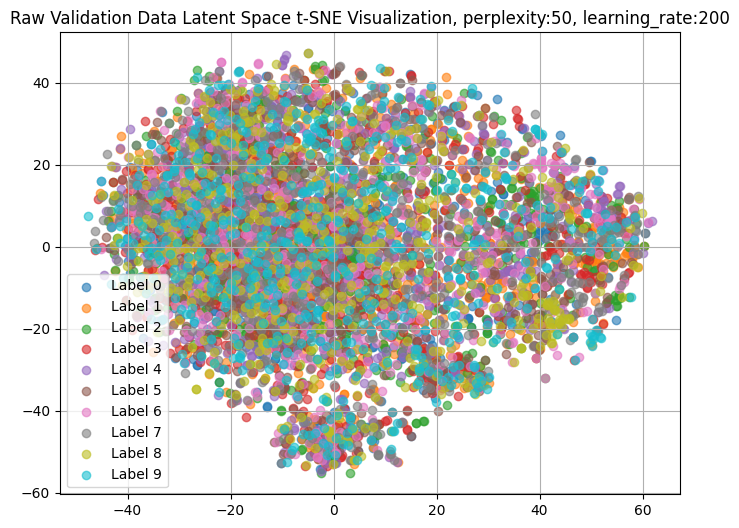

Final KL-Divergence: 2.833732843399048


In [85]:
perplexities = [50]
learning_rates = [200]

latent_vectors = trial_encoder_model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_val, "Raw Validation Data Latent Space t-SNE Visualization", 2)

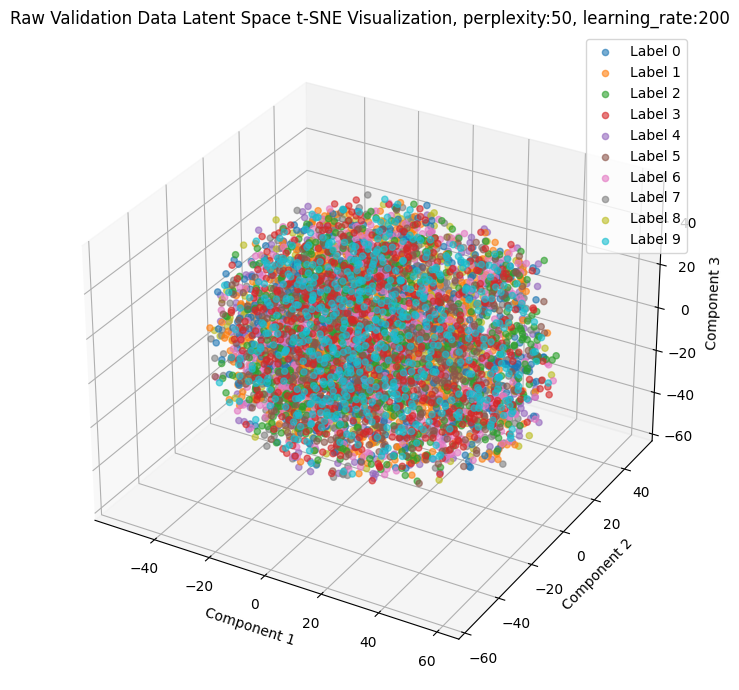

Final KL-Divergence: 2.623887062072754


In [86]:
for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_val, "Raw Validation Data Latent Space t-SNE Visualization", 3)

### **WITH DENOISING**

#### LAST MODEL

In [12]:
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final-multiband/keras/default/1"
model = tf.keras.models.load_model(os.path.join(save_dir, f'LSTM_{attempt}.keras'))

I0000 00:00:1752658324.385756      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.420     0.435     0.427       685
           1      0.231     0.237     0.234       684
           2      0.306     0.330     0.317       685
           3      0.313     0.296     0.305       685
           4      0.309     0.288     0.298       684
           5      0.383     0.399     0.391       685
           6      0.356     0.342     0.349       685
           7      0.304     0.289     0.296       685
           8      0.337     0.349     0.343       684
           9      0.303     0.301     0.302       684

    accuracy                          0.327      6846
   macro avg      0.326     0.327     0.326      6846
weighted avg      0.326     0.327     0.326      6846



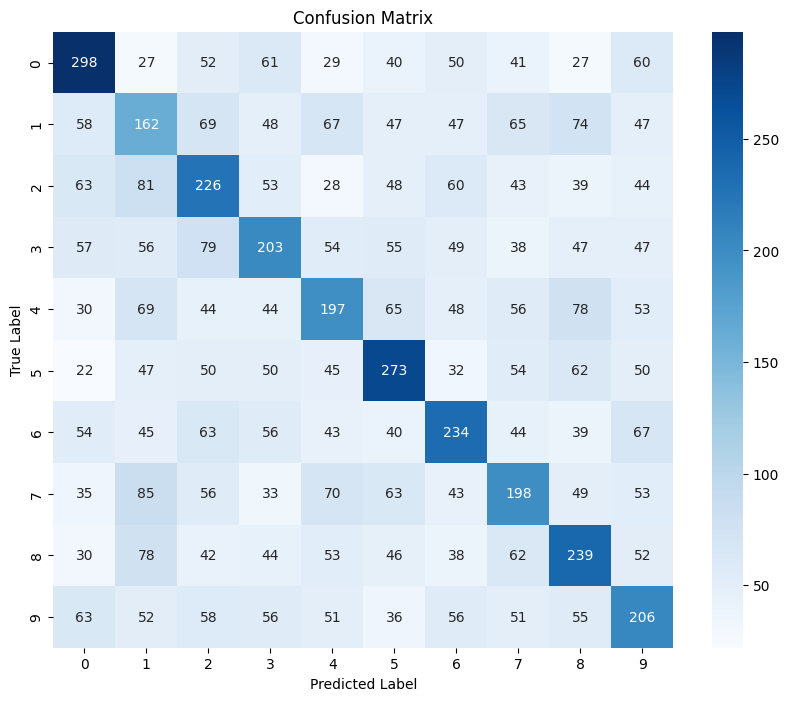

In [14]:
class_names = [str(i) for i in range(10)]
evaluate_model(model, X_val, y_val, class_names)

#### BEST MODEL

In [15]:
import tensorflow as tf
import os

save_dir = f"/kaggle/input/best-lstm-final-multiband/keras/default/1"
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_LSTM_{attempt}.keras'))

##### TRAIN DATA

856/856 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.481     0.706     0.572      2738
           1      0.431     0.396     0.412      2739
           2      0.470     0.410     0.438      2738
           3      0.510     0.370     0.429      2738
           4      0.388     0.483     0.430      2739
           5      0.516     0.536     0.526      2738
           6      0.463     0.430     0.446      2738
           7      0.437     0.314     0.366      2738
           8      0.533     0.557     0.545      2739
           9      0.437     0.455     0.446      2739

    accuracy                          0.466     27384
   macro avg      0.467     0.466     0.461     27384
weighted avg      0.467     0.466     0.461     27384



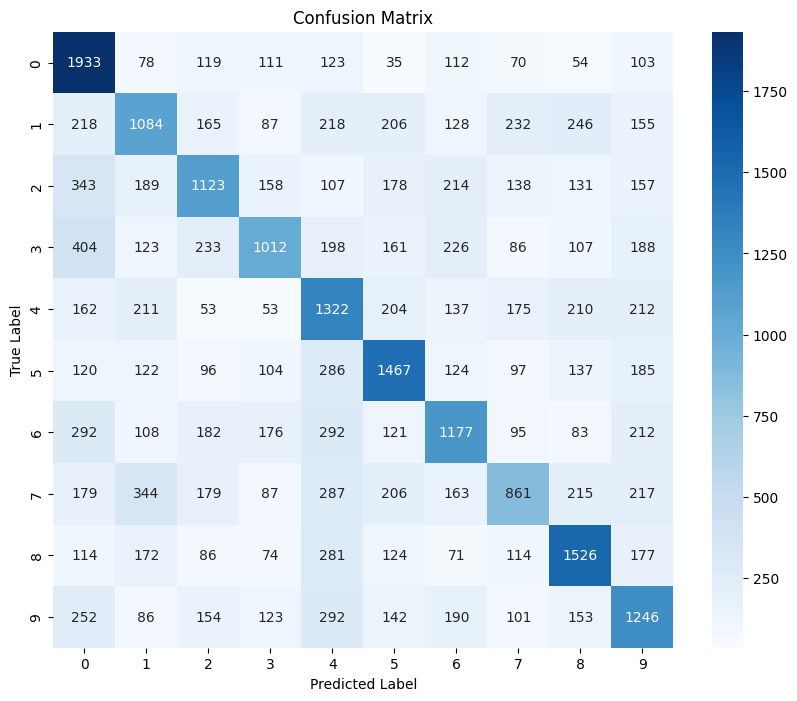

In [16]:
evaluate_model(best_model, X_train, y_train, class_names)

In [25]:
encoder_model = Model(inputs=best_model.input, outputs=best_model.get_layer('latent_vector').output)
encoder_model.compile()

latent_vectors = encoder_model.predict(X_train)
y_true_train = np.argmax(y_train, axis=1)
print_metrics(calculate_metrics(latent_vectors, y_true_train))

856/856 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step


=================================================== METRICS  SUMMARY ===================================================
Label      | Theta Min       | Theta Max       | Theta Avg       | Euclidean Min   | Euclidean Max   | Euclidean Avg  
------------------------------------------------------------------------------------------------------------------------
0          | 0.000000        | 131.200053      | 72.012952       | 0.000006        | 7.105207        | 3.792631       
1          | 25.469460       | 133.915035      | 76.199204       | 1.592247        | 7.322033        | 3.884727       
2          | 0.000000        | 132.018078      | 77.465658       | 0.000001        | 7.250134        | 3.890128       
3          | 0.000000        | 130.598576      | 76.923993       | 0.000001        | 6.889210        | 3.887188       
4          | 0.000000        | 130.135913      | 73.790828       | 0.000002        | 6.735545        | 3.855777       

856/856 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step


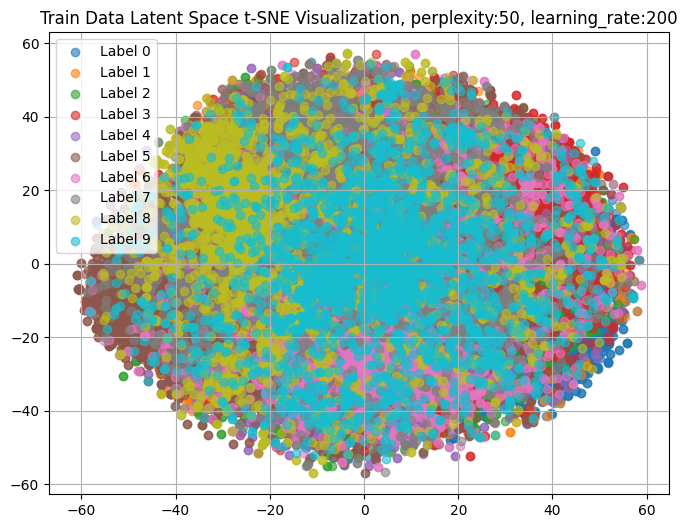

Final KL-Divergence: 3.9955716133117676


In [26]:
perplexities = [50]
learning_rates = [200]

latent_vectors = encoder_model.predict(X_train)
y_true_train = np.argmax(y_train, axis=1)

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_train, "Train Data Latent Space t-SNE Visualization", 2)

856/856 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step


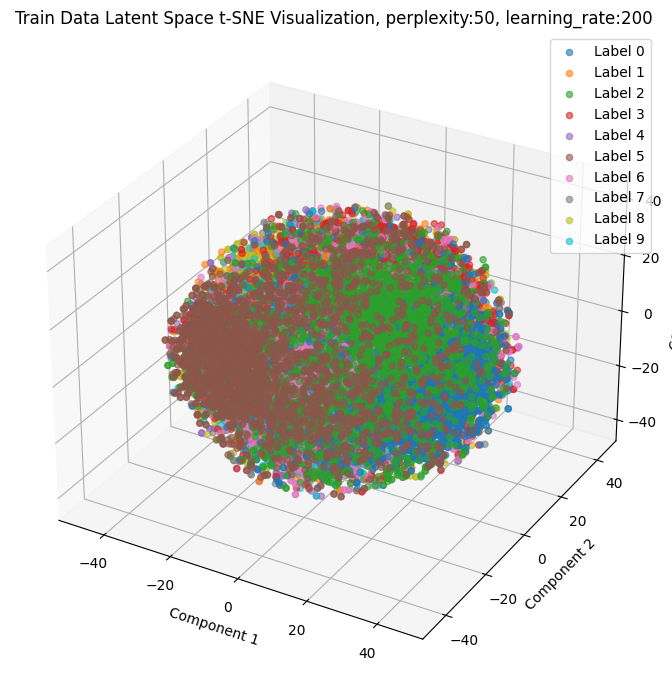

Final KL-Divergence: 3.6533682346343994


In [27]:
latent_vectors = encoder_model.predict(X_train)
y_true_train = np.argmax(y_train, axis=1)

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_train, "Train Data Latent Space t-SNE Visualization", 3)

##### VALIDATION DATA

214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.318     0.486     0.385       685
           1      0.228     0.202     0.214       684
           2      0.257     0.225     0.240       685
           3      0.274     0.197     0.229       685
           4      0.234     0.294     0.260       684
           5      0.307     0.312     0.309       685
           6      0.286     0.263     0.274       685
           7      0.239     0.169     0.198       685
           8      0.293     0.289     0.291       684
           9      0.225     0.249     0.236       684

    accuracy                          0.269      6846
   macro avg      0.266     0.269     0.264      6846
weighted avg      0.266     0.269     0.264      6846



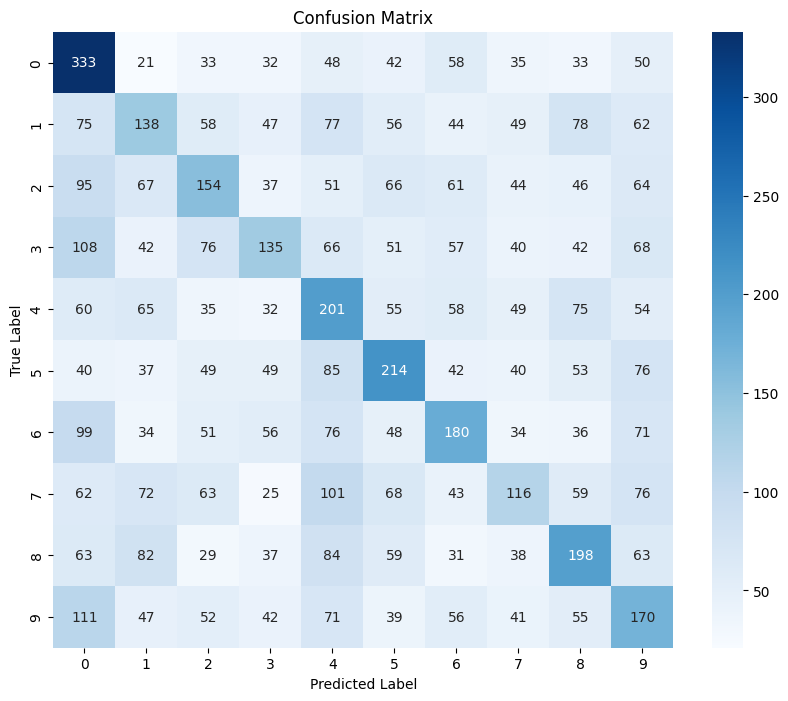

In [19]:
evaluate_model(best_model, X_val, y_val, class_names)

In [21]:
encoder_model = Model(inputs=best_model.input, outputs=best_model.get_layer('latent_vector').output)
encoder_model.compile()

latent_vectors = encoder_model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)
print_metrics(calculate_metrics(latent_vectors, y_true_val))

214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


=================================================== METRICS  SUMMARY ===================================================
Label      | Theta Min       | Theta Max       | Theta Avg       | Euclidean Min   | Euclidean Max   | Euclidean Avg  
------------------------------------------------------------------------------------------------------------------------
0          | 0.027976        | 126.855378      | 76.187216       | 0.000905        | 6.376523        | 3.906180       
1          | 32.404117       | 129.344421      | 79.320809       | 1.835037        | 6.810135        | 3.997812       
2          | 0.055953        | 128.669764      | 79.471423       | 0.002512        | 7.210763        | 3.957255       
3          | 2.294820        | 124.716287      | 78.713226       | 0.122855        | 6.758593        | 3.940700       
4          | 0.048457        | 129.743114      | 77.130662       | 0.002904        | 6.672343        | 3.929773       


214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


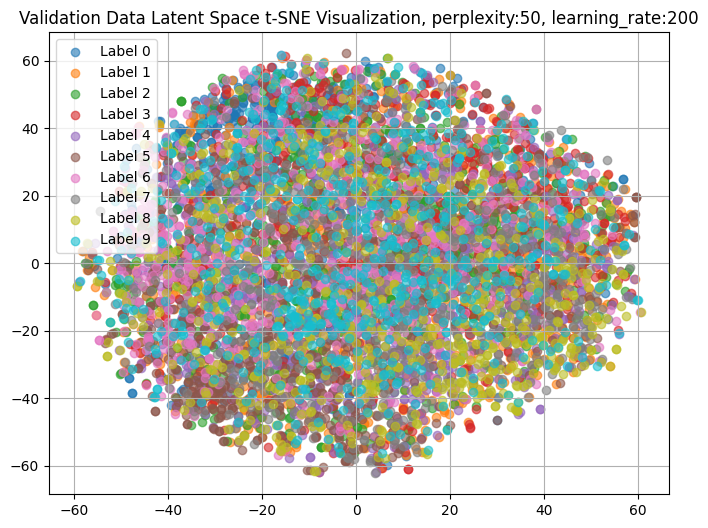

Final KL-Divergence: 3.0729570388793945


In [23]:
latent_vectors = encoder_model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)

perplexities = [50]
learning_rates = [200]

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_val, "Validation Data Latent Space t-SNE Visualization", 2)

214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


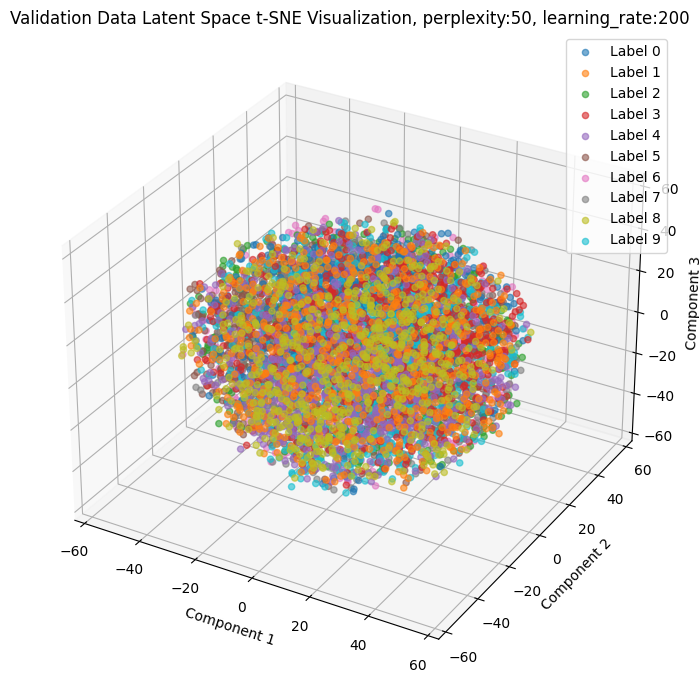

Final KL-Divergence: 2.814345121383667


In [24]:
latent_vectors = encoder_model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)

for p in perplexities:
    for lr in learning_rates:
        visualize_tSNE(p, lr, latent_vectors, y_true_val, "Validation Data Latent Space t-SNE Visualization", 3)